# ***Multivariate LSTM for Stock Price Forecasting***

**Created by Saifur Rahman, 2024.**

## **0. Required libraries.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

## **1. Data Pre-processing**


Download data from: https://www.nasdaq.com/market-activity/quotes/historical



### I. Load data into dataframes and clean them.


In [2]:
# List of stock symbols
stockList = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']

# Dictionary to hold DataFrames for each stock
df_dict = {}

# Define the features to be used for scaling
features = ['Close/Last', 'Open', 'High', 'Low', 'Volume']

# Load data for each company into separate DataFrames
for stock in stockList:
    df = pd.read_csv(f'{stock}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Clean the data by removing '$' and ',' from numerical columns
    df[features] = df[features].replace('[\$,]', '', regex=True).astype(float)

    df_dict[stock] = df

### II. Split data into train and test sets and visualize them.

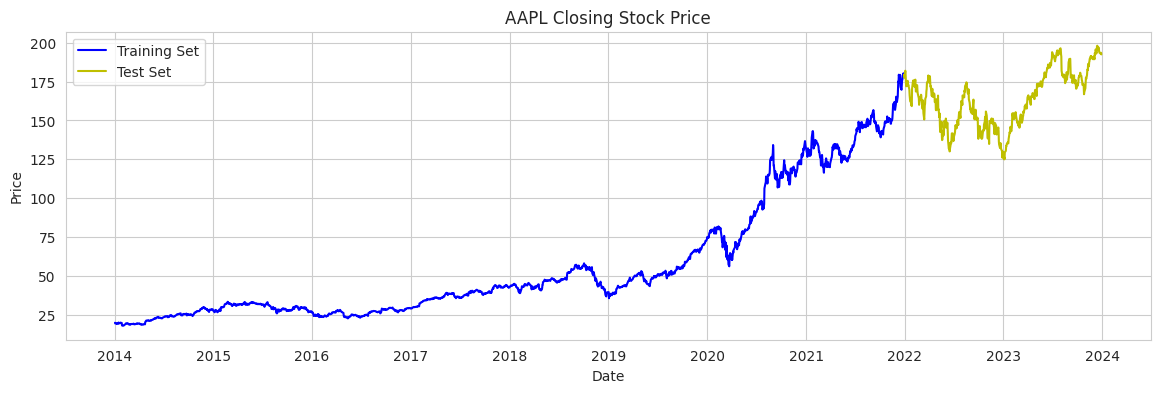

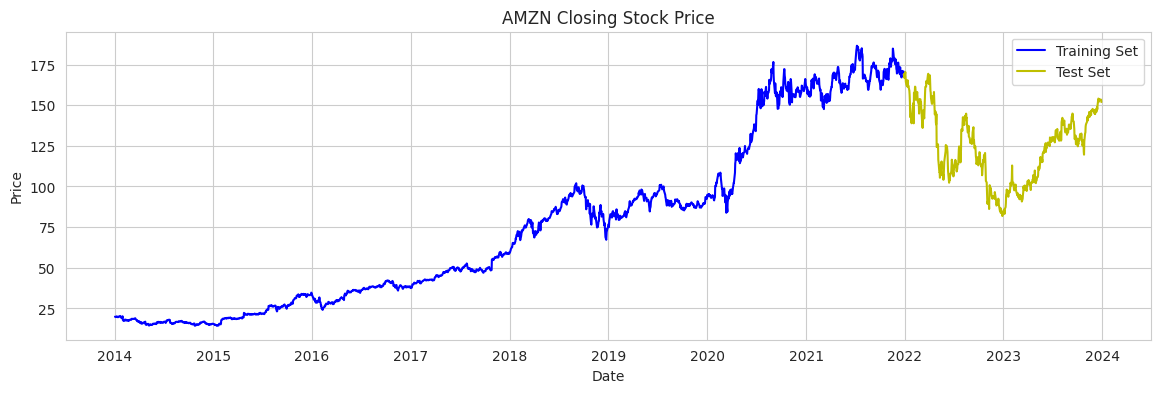

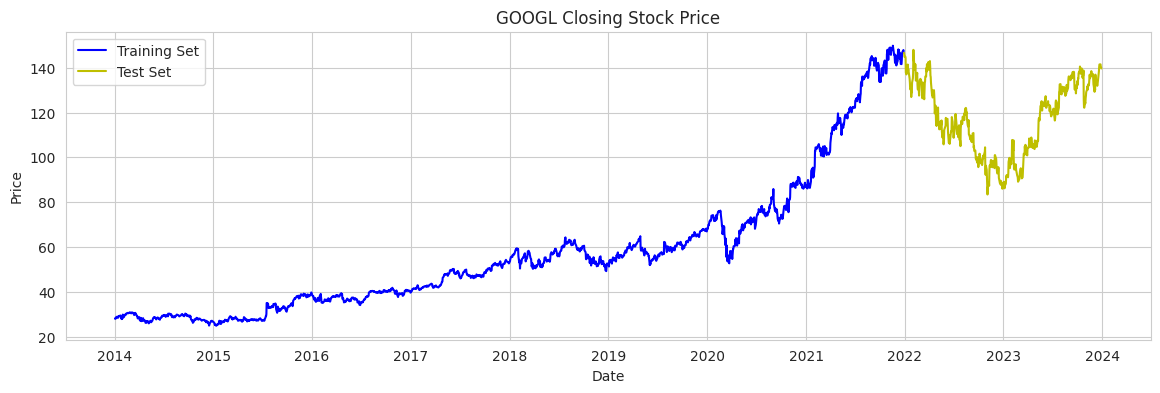

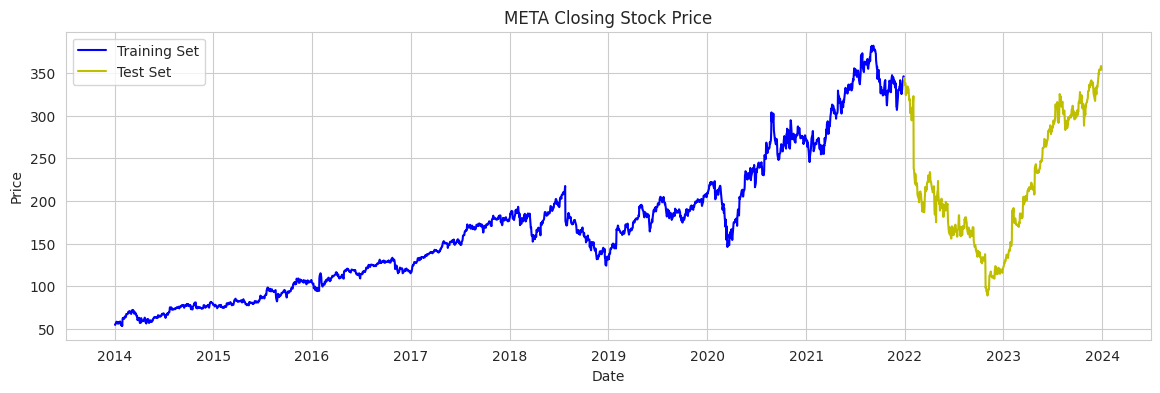

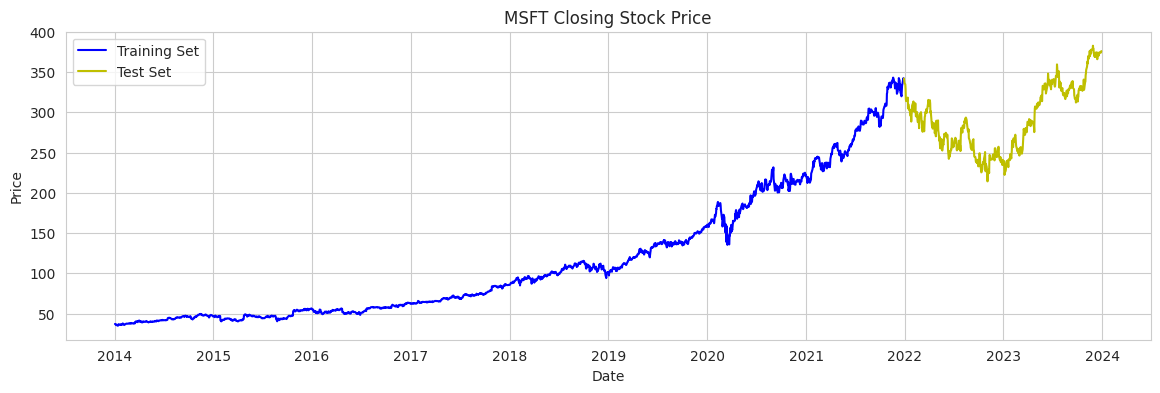

In [3]:
# Split data for each company into training and testing sets
train_data = {}
test_data = {}
for stock in stockList:
    data = df_dict[stock]
    train, test = train_test_split(data, test_size=0.2, shuffle=False)
    train_data[stock] = train
    test_data[stock] = test

# Plot stock data for each companies
for stock in stockList:
    plt.figure(figsize=(14, 4))
    plt.plot(train_data[stock]['Date'], train_data[stock]['Close/Last'], label='Training Set', linestyle='-', color='b')
    plt.plot(test_data[stock]['Date'], test_data[stock]['Close/Last'], label='Test Set', linestyle='-', color='y')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend()
    plt.title(stock + ' Closing Stock Price')
    plt.show()

### III. Scale features using MinMaxScaler

In [4]:
# Data transformation using MinMaxScaler
transform_train = {}
transform_test = {}
scaler = {}

for stock in stockList:
    if all(feature in train_data[stock] for feature in features):
        sc = MinMaxScaler(feature_range=(0, 1))
        train_data_scaled = sc.fit_transform(train_data[stock][features])
        test_data_scaled = sc.transform(test_data[stock][features])
        transform_train[stock] = train_data_scaled
        transform_test[stock] = test_data_scaled
        scaler[stock] = sc
    else:
        print(f"Missing features for {stock}: {', '.join(set(features) - set(train_data[stock].columns))}")

### IV. Create train and test sets using scaled data.

In [5]:
# Create train and test sets for LSTM model
trainset = {}
testset = {}
for stock in stockList:
    if stock in transform_train and stock in transform_test:
        trainset[stock] = {}
        X_train = []
        y_train = []
        for i in range(60, transform_train[stock].shape[0]):
            X_train.append(transform_train[stock][i-60:i, :])
            y_train.append(transform_train[stock][i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[stock]["X"] = X_train
        trainset[stock]["y"] = y_train

        testset[stock] = {}
        X_test = []
        y_test = []
        for i in range(60, transform_test[stock].shape[0]):
            X_test.append(transform_test[stock][i-60:i, :])
            y_test.append(transform_test[stock][i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[stock]["X"] = X_test
        testset[stock]["y"] = y_test

### V. Print shapes of train and test data.

In [6]:
# Create a DataFrame to store the shapes of train and test sets
arr_buff = []
for stock in stockList:
    if stock in trainset and stock in testset:
        buff = {}
        buff["X_train"] = trainset[stock]["X"].shape
        buff["y_train"] = trainset[stock]["y"].shape
        buff["X_test"] = testset[stock]["X"].shape
        buff["y_test"] = testset[stock]["y"].shape
        arr_buff.append(buff)

df_shapes = pd.DataFrame(arr_buff, index=stockList)
print(df_shapes)

             X_train  y_train        X_test  y_test
AAPL   (1952, 60, 5)  (1952,)  (444, 60, 5)  (444,)
AMZN   (1952, 60, 5)  (1952,)  (444, 60, 5)  (444,)
GOOGL  (1952, 60, 5)  (1952,)  (444, 60, 5)  (444,)
META   (1952, 60, 5)  (1952,)  (444, 60, 5)  (444,)
MSFT   (1952, 60, 5)  (1952,)  (444, 60, 5)  (444,)


## **2. LSTM Model**


### Create and train LSTM model.

In [8]:
# Create an LSTM model
def create_lstm_model(input_shape):
    regressor = Sequential()
    regressor.add(Input(shape=input_shape))
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    regressor.add(Dense(units=1))
    return regressor

# Fitting the LSTM model to the training data
models = {}
for stock in stockList:
    if stock in trainset and stock in testset:
        model = create_lstm_model((trainset[stock]["X"].shape[1], trainset[stock]["X"].shape[2]))
        model.compile(optimizer='rmsprop', loss='mean_squared_error')
        print(f"Fitting to {stock}")
        model.fit(trainset[stock]["X"], trainset[stock]["y"], epochs=50, batch_size=16)
        models[stock] = model

Fitting to AAPL
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0163
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0072
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0056
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0037
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0041
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031
Epoch 12/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031
Epoch 13/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030
Epoch 14/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0029
Epoch 15/50
122/122 ━━━━━━━

## **3. Predictions**


### Make and visualize predictions.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


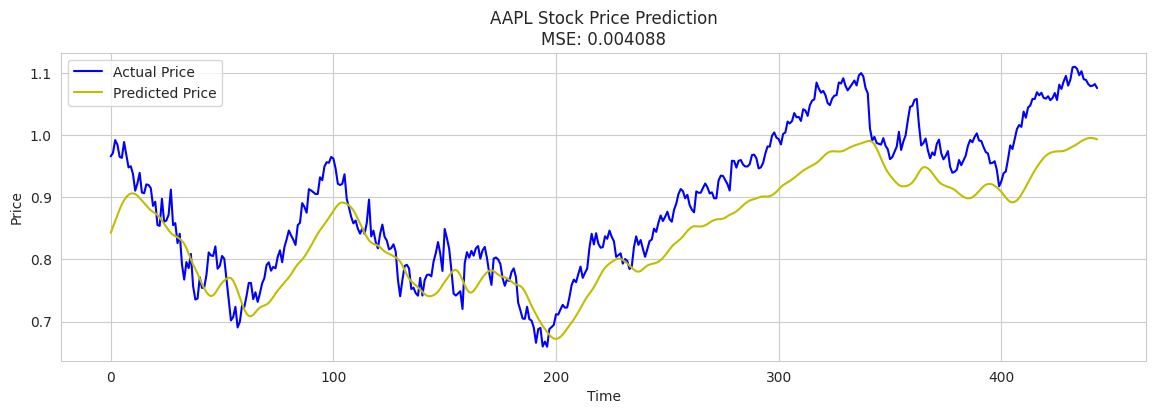

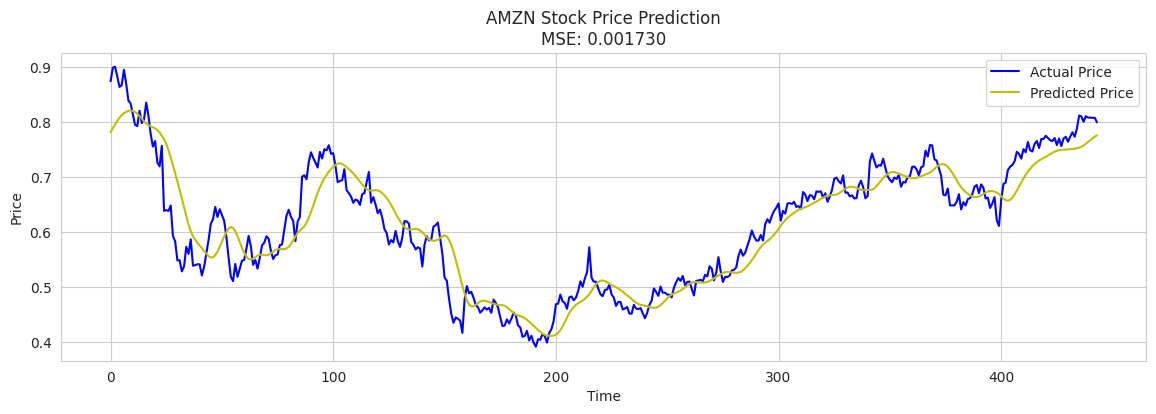

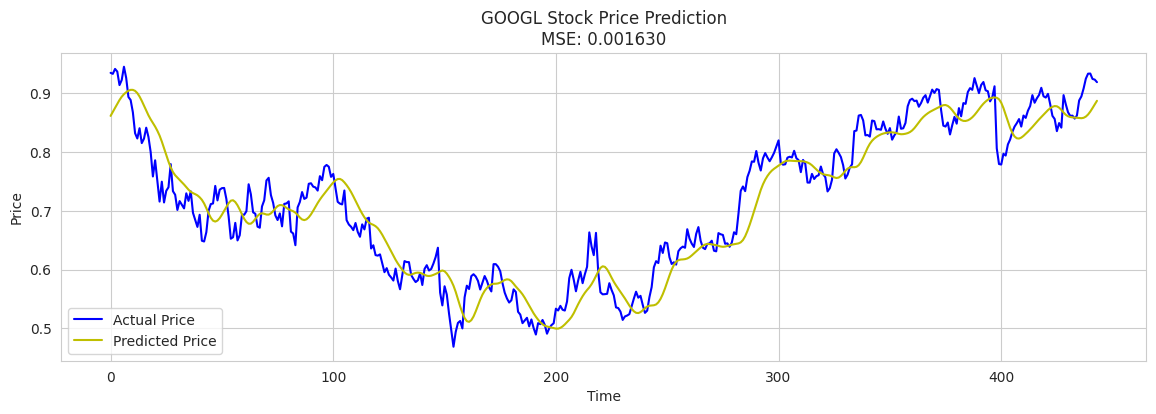

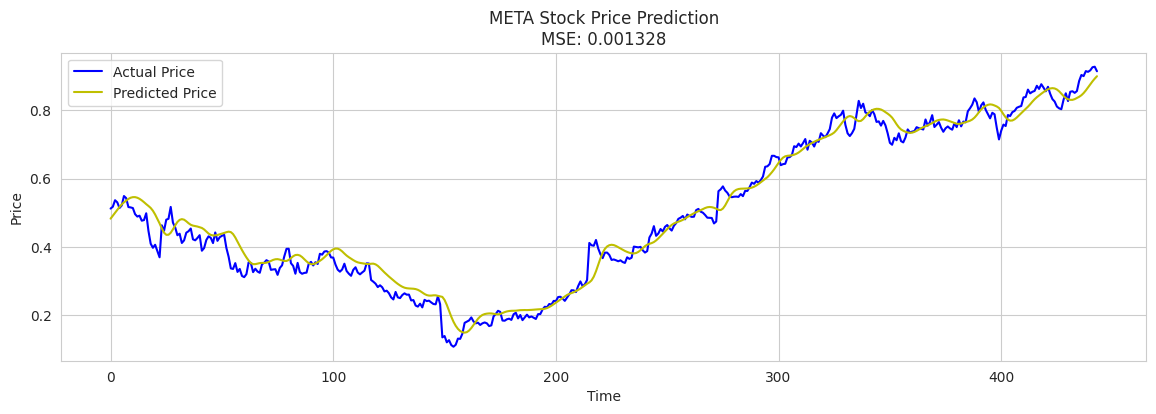

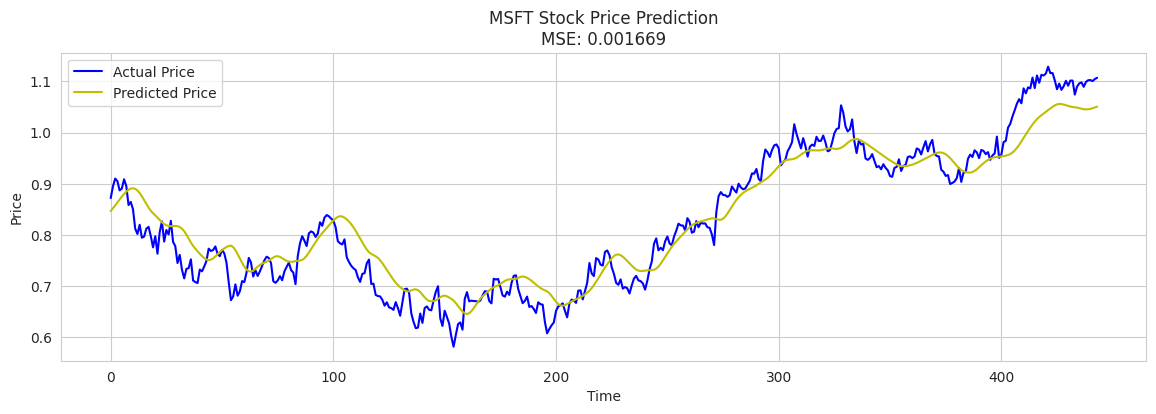

In [9]:
# Make predictions using the trained LSTM models
predictions = {}
for stock in stockList:
    if stock in models and stock in testset:
        model = models[stock]
        X_test = testset[stock]["X"]
        y_test = testset[stock]["y"]
        y_pred = model.predict(X_test)
        predictions[stock] = {"y_test": y_test, "y_pred": y_pred}

# Plot the predictions
for stock in stockList:
    if stock in predictions:
        y_test = predictions[stock]["y_test"]
        y_pred = predictions[stock]["y_pred"]
        mse = mean_squared_error(y_test, y_pred)
        plt.figure(figsize=(14, 4))
        plt.plot(y_test, label='Actual Price', color='b')
        plt.plot(y_pred, label='Predicted Price', color='y')
        plt.ylabel('Price')
        plt.xlabel('Time')
        plt.legend()
        plt.title(f'{stock} Stock Price Prediction\nMSE: {mse:.6f}')
        plt.show()